In [14]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings #to ignore warnings
warnings.filterwarnings('ignore');

In [67]:
#creating dataframes
load_train = pd.read_csv('train.csv', na_values=["?"]) #na_values will replace "?" with NaN
load_test = pd.read_csv('test.csv', na_values=["?"])
load_submission = pd.read_csv('sample_submission.csv')

#making copies to protect the original data
train_original = load_train.copy()
test_original = load_test.copy()
submission_originial = load_submission.copy()

train = load_train
test = load_test
sumbission = load_submission

In [68]:
def clean_data(df):
    #Replace missing values with the mode for categorical and or mean/median for numerical
    #train dataset
    df['property_damage'].fillna(df['property_damage'].mode()[0], inplace = True)
    df['police_report_available'].fillna(df['police_report_available'].mode()[0], inplace = True)
    df['collision_type'].fillna(df['collision_type'].mode()[0], inplace = True)
    
    #drop the _c39 column since it consists of nan only
    df = df.drop(['_c39'], axis = 'columns')
    
    return df

In [69]:
#clean the datasets
train = clean_data(train)
test = clean_data(test)

In [70]:
#sorting missing values columns and filtering 0 missing value cols
missing_value_cols = train.isnull().sum()
missing_value_cols = missing_value_cols[missing_value_cols != 0]
missing_value_cols.sort_values(ascending = False)

Series([], dtype: int64)

In [71]:
#property damage
train.property_damage.value_counts()

NO     479
YES    221
Name: property_damage, dtype: int64

**Correlations on Data**

In [72]:
def one_hot_encoding(df):
    #import the library
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    #set targets
    columns_to_fit = [ 'insured_sex', 'insured_occupation', 'insured_relationship', 
                      'policy_state', 'property_damage',  'witnesses', 'police_report_available',
                      'incident_state', 'auto_model', 'auto_make','authorities_contacted', 'months_as_customer', 
                      'insured_hobbies', 'incident_city', 'witnesses', 'insured_education_level' ]
    #removed
    #movded 'collision_type', 'collision_type'
    #loop df and apply encoding
    for col in df.columns:
        if col in columns_to_fit:
            df[col] = le.fit_transform(df[col])
    return df 

In [73]:
train.authorities_contacted.unique()

array(['Police', 'Fire', 'Other', 'Ambulance', 'None'], dtype=object)

In [74]:
#apply one hot encoding
train = one_hot_encoding(train)
test = one_hot_encoding(test)

In [75]:
train.authorities_contacted.unique()

array([4, 1, 3, 0, 2])

<b> 7.2 Feature Engineering

In [76]:
def auto_age(df):
    
    #calculate the years of the auto_year or car
    from datetime import datetime
    current_date_time = datetime.now()
    #replace the YYYY date with number of years
    df['auto_age'] = (current_date_time.year - df['auto_year'])
    #add the years_as_customer
    df['years_as_customer'] = df.months_as_customer//12
    #add the months_out_of_12_as_customer
    df['no_months_as_customer'] = df.months_as_customer%12
    
    return df

In [77]:
#apply feature engineering on the datasets
train = auto_age(train)
test = auto_age(test)

In [78]:
#verify processing: years and months of customer 1
f'ID: {train.Customer_ID[0]}, Years: {train.years_as_customer[0]}, Months: {train.no_months_as_customer[0]}'

'ID: Customer_541, Years: 16, Months: 7'

In [83]:
def preprocessing_datasets(df):
    #add policy period by the time of the incident
    #use copy df to create it and add to the original df
    dftr = df.copy()
    dftr['incident_date'] = pd.to_datetime(dftr['incident_date'])
    dftr['policy_bind_date'] = pd.to_datetime(dftr['policy_bind_date'])
    df['policy_period'] = (dftr.incident_date - dftr.policy_bind_date)
    #Convert days in policy_period from dtype timedelta to int64
    df['policy_period'] = df['policy_period'].dt.days
     #convert string float fractions in policy_csl into floats
    df_ = df.copy()
    df_[["numerator", "denominator"]] = df_["policy_csl"].str.split("/", expand=True)
    df["policy_csl_float"] = df_["numerator"].astype(float) / df_["denominator"].astype(float)

    return df

In [84]:
#convtert the dates
train = preprocessing_datasets(train)
test = preprocessing_datasets(test)

In [85]:
#confirm processing: policy_period is the number of days of the policy when the accident took place
f'ID: {train.Customer_ID[0]}, Policy period: {test.policy_period[0]} days , Policy CLS: {train.policy_csl_float[0]}'

'ID: Customer_541, Policy period: 182 days , Policy CLS: 0.5'

In [86]:
train.dtypes

Customer_ID                     object
months_as_customer               int32
age                              int64
insured_sex                      int32
insured_education_level          int32
insured_occupation               int32
insured_hobbies                  int32
insured_relationship             int32
capital-gains                    int64
capital-loss                     int64
policy_number                    int64
policy_bind_date                object
policy_state                     int32
policy_csl                      object
policy_deductable                int64
incident_location               object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                  int32
bodily_injuries                  int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
incident_date                   object
incident_type                   object
collision_type           

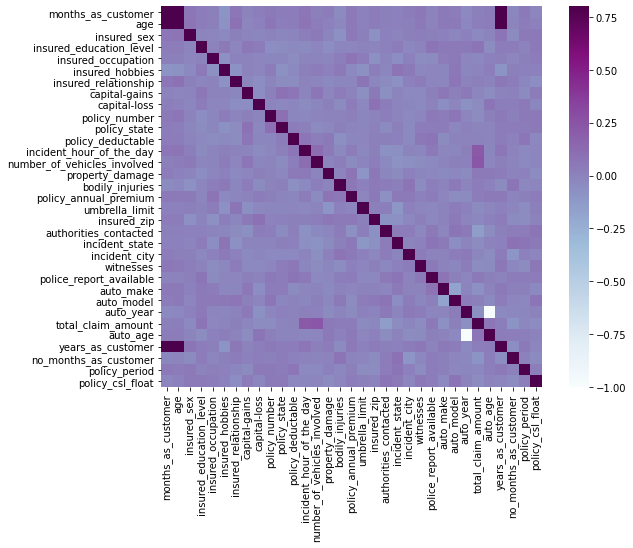

In [88]:
#view Correlations
matrix = train.corr()
f, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(matrix, vmax = 0.8, square = True, cmap = 'BuPu');

<b>7.3 Drop unwanted columns</b>

In [89]:
#appply function to delete columns
def drop_columns(df):
    
    #set targets
    columns_to_filter = [ 'Customer_ID', 'incident_location','policy_csl', 'policy_number', 'incident_city', 
                         'insured_zip', 'incident_date', 'policy_bind_date', 'incident_date']

    
    #loop df and delete columns
    for col in df.columns:
        if col in  columns_to_filter:
            df = df.drop(col, axis = 1)
    
    return df 

In [90]:
#drop unwanted columns
train = drop_columns(train)
test = drop_columns(test)

In [91]:
#verify dropped columns
assert 'Customer_ID' not in train.columns

# 8. Building The Model

In [92]:
#drop target variable: total_claim_amount and assign it to y
X = train.drop('total_claim_amount', axis = 1)
y = train.total_claim_amount

In [93]:
#Creating Dummies
X = pd.get_dummies(X)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [94]:
#split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [95]:
#import the libraries
#import lib and mod
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

#instantiate the model
model = LinearRegression()
#set parameters
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=None)

#fit/train the model
grid.fit(X_train, y_train);

In [96]:
#predict the X_test
y_pred_1 = grid.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_1))
print(f'Grid Model RMSE:{rmse}')

Grid Model RMSE:20731.332644442347


# Model 2

In [97]:
from sklearn.ensemble import GradientBoostingRegressor #For Regression
#Instantiate the model
regress_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1)
#fit the model
regress_2.fit(X_train, y_train);

In [98]:
#prediction with GB
y_pred_2 = regress_2.predict(X_test)

#root mean square error and mean squeare error of both models
MSE = np.square(np.subtract(y_test,y_pred_2)).mean()
rmse = sqrt(mean_squared_error(y_test, y_pred_2))
print(f'Regress_2 Model RMSE: {rmse}, MSE: {MSE}')

Regress_2 Model RMSE: 21822.680179584077, MSE: 476229370.2204117


# Model 3: GradientBoostingRegressor and AdaBoostRegressor

In [99]:
#import libraries
from sklearn  import ensemble #can also use sklearn.ensemble import GradientBoostRegressor
#set parameters
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
#fit GBR
reg_ = ensemble.GradientBoostingRegressor(**params)
reg_.fit(X_train, y_train);

In [100]:
#fit adaboost classifier
reg_1=ensemble.AdaBoostRegressor()
reg_1.fit(X_train, y_train);

In [101]:
#prediction with GB and AB
reg_pred = reg_.predict(X_test)
reg1_pred = reg_1.predict(X_test)

#root mean square error
rmse = sqrt(mean_squared_error(y_test, reg_pred))
rmse1 = sqrt(mean_squared_error(y_test,reg1_pred))
rmse, rmse1

(20872.194713534514, 20045.339414713642)

In [102]:
#Save Highest Score
AB_claim_pred = reg_1.predict(test)
#Adds total_claim_amout column and fill it
submission = pd.read_csv('sample_submission.csv')

submission['total_claim_amount'] = AB_claim_pred
#Adds Customer_ID and fill it
submission['Customer_ID'] = test_original['Customer_ID']

#Convert submission to .csv file format
submission.to_csv('submissions/AB_claim_pred.csv', index = False)

# Randomized Search

In [103]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as sp_rand
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

#instantiate the model
model = LinearRegression()
#set parameters
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=None)

#fit/train the model
grid.fit(X_train, y_train);

In [104]:
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_train, y_train);
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha);

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0F5B7E30>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)
0.6581668351414903
0.6664923449182928


In [105]:
#prediction with GB and AB
rs_pred = rsearch.predict(X_test)
grid_pred = grid.predict(X_test)
#root mean square error
rmse = sqrt(mean_squared_error(y_test, rs_pred))
rmse1 = sqrt(mean_squared_error(y_test, grid_pred))
rmse, rmse1

(20758.977610854272, 20731.332644442347)

# Polynomial and Linear Regression

In [106]:
#Importing Linear Regression
from sklearn.linear_model import LinearRegression

# Training Model
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
# importing libraries for polynomial transform
from sklearn.preprocessing import PolynomialFeatures
# for creating pipeline
from sklearn.pipeline import Pipeline

# creating pipeline and fitting it on data
Input=[('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]

pipe=Pipeline(Input)
pipe.fit(X_train,y_train);

In [108]:
#predict wit linear
linear_pred=lm.predict(X_test)
#predict with polynomial
poly_pred=pipe.predict(X_test)

In [109]:
print('RMSE for Polynomial Regression=>',np.sqrt(mean_squared_error(y_test,poly_pred)))
print('RMSE for Linear Regression=>',np.sqrt(mean_squared_error(y_test,linear_pred)))

RMSE for Polynomial Regression=> 81241.61419916611
RMSE for Linear Regression=> 20731.332644043752


# Ordinary Least Squares

In [110]:
#import libraries
import statsmodels.api as sm
# adding a constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
#train the model
model = sm.OLS(y_train, X_train).fit()

In [111]:
#prediction with GB and AB
ols_pred = model.predict(X_test) 
#root mean square error
rmse = sqrt(mean_squared_error(y_test, ols_pred))
rmse

20731.33264271839

# Simplified LinearRegression Model

<b> LRM</b>

In [112]:
#import mse
from sklearn.metrics import mean_squared_error

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
lin_reg_mod = LinearRegression()
#fit the model
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
#make a prediction
final_pred = lin_reg_mod.predict(X_test)
#RMSE
rmse = (sqrt(mean_squared_error(y_test, final_pred)))
rmse

20731.332644043752

In [116]:
final_pred = lin_reg_mod.predict(test)
#Adds total_claim_amout column and fill it
submission = pd.read_csv('sample_submission.csv')
submission['total_claim_amount'] = final_pred
#Adds Customer_ID and fill it
submission['Customer_ID'] = test_original['Customer_ID']
#Convert submission to .csv file format
submission.to_csv('final_pred_model.csv', index = False)

# Complex Linear Regression Models

In [117]:
#split test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# import necessary libraries
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot


# 1. evaluate a model
def evaluate_model(X, y, model):
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    return absolute(scores)

In [118]:
# 2. plot the dataset and the model's line of best fit
def best_fit(X, y, model):
    #fits the model to the training data
    model.fit(X, y)
    #return the fitted model
    return model

# 3. define the model, evalutate and fit it
model = LinearRegression()
# evaluate model
results = evaluate_model(X_test, y_test, model)
#predict results
print(f'Mean MAE:{mean(results)}, STD: {std(results)}')
# fit the model
fitted_model = best_fit(X_train, y_train, model)

Mean MAE:19513.743706270492, STD: 3704.4598644252983


In [119]:
# 3. define the model, evalutate and fit it
model = LinearRegression()
# evaluate model
results = evaluate_model(X_test, y_test, model)
#predict results
print(f'Mean MAE:{mean(results)}, STD: {std(results)}')
# fit the model
fitted_model = best_fit(X_train, y_train, model)
#predict the target
pred_results = fitted_model.predict(X_test)
#RMSE
rmse = (sqrt(mean_squared_error(y_test, pred_results)))
rmse

Mean MAE:19513.743706270492, STD: 3704.4598644252983


20731.332644043752

# Linear Regression with QuantileTransformer

In [120]:
#import libraries
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer


transformer = QuantileTransformer(output_distribution = 'normal')
regressor = LinearRegression()
regression_model_3 = TransformedTargetRegressor(regressor = regressor, transformer = transformer)
#Model3 with transformed target variable 
regression_model_3.fit(X_train, y_train);

In [121]:
#predict and measure RMSE
y_pred_3 = regression_model_3.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_3))
f'Root Mean Square Error: {rmse}'

'Root Mean Square Error: 20711.926606755063'